# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. For some of the more standard plots such as transect contours, I also experiment with my Ocean Toolbox package.

## Goals

* Quantify the energy content and fluxes of observed internal waves
* Use the observed waves (after quantifying their wavenumbers and frequency) in ray tracing with the satGEM 4D temperature-salinity-velocity fields to track the propogation of waves (forward and backwards in time). 
* Try to see if the lee waves are imparting a drag on the mean flow (**How do I do this???**)


### CURRENT NOTES/QUESTIONS/TO-DO:
* Ray Tracing tests
* Add mean flow vector (its somewhere in the older lee wave scripts)
* Add bathymetry to transect plots


* **UPDATE**: **10/1/18 - After speaking with alberto I went back and changed the way that I am doing potential energy calculations and now the wavenumbers are much smaller (roughly 10-15 km) which makes way more sense. This was change from using adiabatic leveling for a reference density to using neutral density (CSIRO CODES) and differencing over a 400 m vertical window.**


* Playing around with the integration limits seems to not change the energy or frequency too much but the horizontal wavelengths do seem sensitive to it.

    * The Lower half of the transect seems to be dominated by an order of magnitude larger wavelengths
    
* If I want to do the energy flux and ray tracing, I think I will pick a couple select packets and isolate them to get more concrete wavenumbers to use in ray tracing.


* Can I use ray tracing to show how energy is transported vs dissipated as the wave travels?


* There is realy strong surface shear in half the profile (1st half) and it seems like that is stopping waves (or causing them to break not really sure. Also , if vertical wavenumber increases with flow and horizontal wavenumber decreases, what effect does that have on the wave as a whole?


**The peaks in internal energy visually correlate well with the velocity anamoly graphs where theres packets of similar anomalies. However, I am not sure why the wave numbers are so big (>100km).**


* Check whether lee waves can actually form over such big sizes


* All the frequencies are near f. (should be vertically propogating energy (but much slower in the vertical compared to the horizontal because low vertical group speed. 


* Doppler shift the frequencies to see what happens. 





In [4]:
# Load Data and relevant modules - this is common to both wayss
%matplotlib inline
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc
import warnings
import cmocean
import matplotlib.colors as colors
import ray_tracing_satGEM as rt
from netCDF4 import Dataset
from datetime import datetime, timedelta


from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.reset()

# Probably Shouldn't do this but they annoy me
warnings.simplefilter("ignore")

pd.options.display.max_rows = 3000
pd.options.display.max_columns = 22

plt.rcParams.update({'font.size':14})


# load data and cut off bottom (its all nans)
ladcp, ctd = data_load.load_data()
wl_max = 1000
wl_min = 400
ctd_bin_size = 1024
ladcp_bin_size = 1024
nfft = 1024

U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
rho = gsw.density.rho(S, T, p_ctd)
N2, n2grid = gsw.Nsquared(S, T, p_ctd)
maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth


S = S[idx_ctd,:]
T = T[idx_ctd,:]
rho = rho[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]


# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids (For plots)
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
depths2 = np.tile(depths, (24,1))
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)

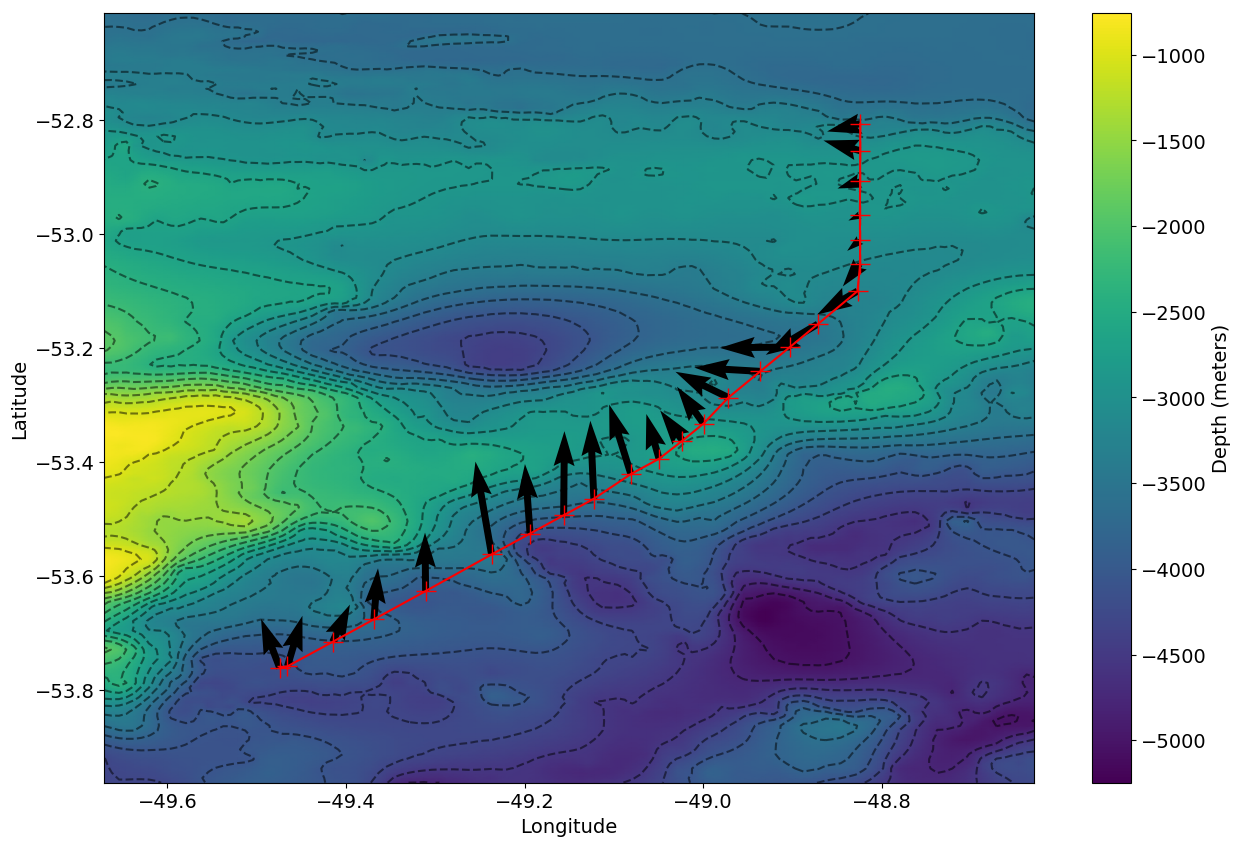

In [5]:
# Plot map of transect and bathymetry
bathy = Dataset('bathy.nc')

buffer = 0.2
latlims = np.array([np.nanmin(lat)-buffer, np.nanmax(lat)+buffer])
latlims = [np.argmin(np.abs(lat_in - bathy['lat'][:])) for lat_in in latlims]
latlims = np.arange(latlims[0], latlims[1])

lonlims = np.array([np.nanmin(lon)-buffer, np.nanmax(lon)+buffer])
lonlims = [np.argmin(np.abs(lon_in - bathy['lon'][:])) for lon_in in lonlims]
lonlims = np.arange(lonlims[0], lonlims[1])

bathy_rev = bathy['elevation'][latlims, lonlims]
lat_b = bathy['lat'][latlims]
lon_b = bathy['lon'][lonlims]

blevels = np.linspace(np.nanmin(bathy_rev), np.nanmax(bathy_rev), 20)
plt.figure(figsize=(15, 10))
plt.pcolormesh(lon_b, lat_b, bathy_rev, shading='gouraud')
c = plt.colorbar()
c.set_label('Depth (meters)')
plt.plot(lon[:].flatten(), lat[:].flatten(), c='r', marker='+', ms=15)
plt.contour(lon_b, lat_b, bathy_rev, colors='k', alpha=.5, levels=blevels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# add mean flow vectors
depth = 2000
cutoff = np.argmin(np.abs(p_ladcp[:] - depth))
Umean, Vmean = oc.depthAvgFlow(U, V, 8, depthRange=depth)
plt.quiver(lon[:].flatten(), lat[:].flatten(), Umean, Vmean)



Text(0,0.5,'Pressure (dB)')

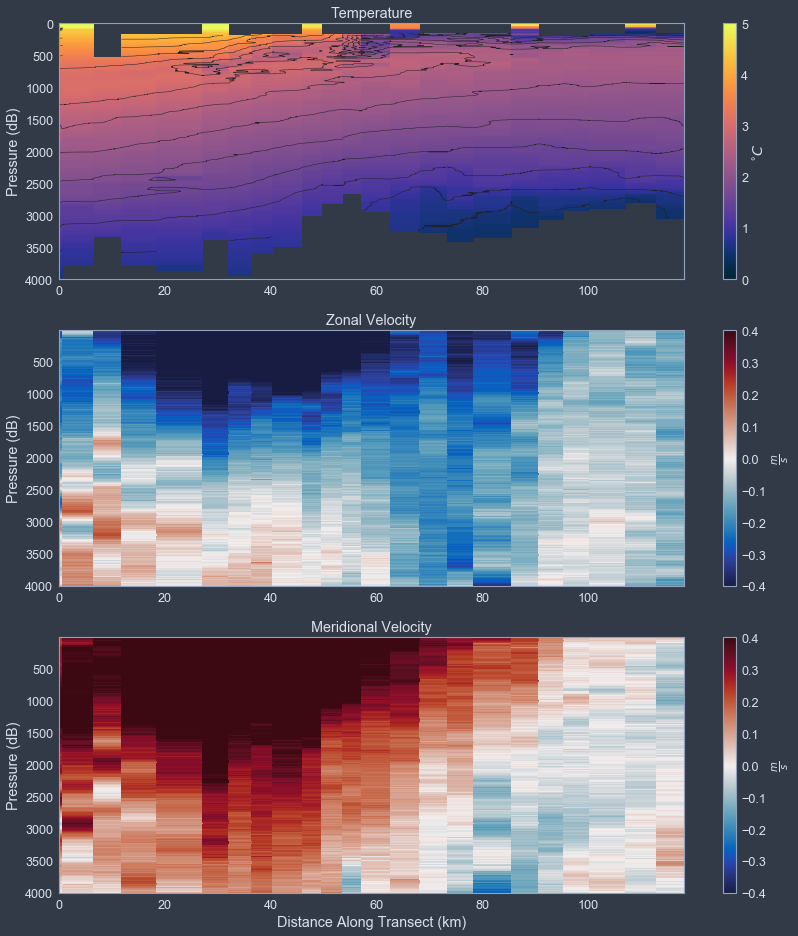

In [3]:
# Plot transect contours of temps and velocities to look at
tlevels = np.linspace(np.nanmin(T), np.nanmax(T), 20)

plt.figure(figsize=(14, 16))
plt.subplot(311)
plt.pcolor(dist.flatten(), p_ctd[:,0].flatten(), T, vmin=0, vmax=5, cmap=cmocean.cm.thermal)
c = plt.colorbar()
plt.contour(dist.flatten(), p_ctd[:,0].flatten(), T, colors='k', linewidths=.5, levels=tlevels)
plt.gca().invert_yaxis()

c.set_label(r'$^{\circ}C$')
plt.title('Temperature')
plt.ylabel('Pressure (dB)')

ulevels = np.linspace(np.nanmin(U), np.nanmax(U), 5)
plt.subplot(312)
plt.pcolor(dist.flatten(), p_ladcp[:,0].flatten(), U,  vmin=-.4, vmax=.4, cmap=cmocean.cm.balance)
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label(r'$\frac{m}{s}$')
plt.title('Zonal Velocity')
plt.ylabel('Pressure (dB)')

plt.subplot(313)
plt.pcolor(dist.flatten(), p_ladcp[:,0].flatten(), V, vmin=-.4, vmax=.4, cmap=cmocean.cm.balance)
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label(r'$\frac{m}{s}$')
plt.title('Meridional Velocity')
plt.xlabel('Distance Along Transect (km)')
plt.ylabel('Pressure (dB)')




**Isopycnal displacements using neutral density from CSIRO matlab function**
* **What is the point of the neutral density vs normal density**
* Isopycnal displacements calcualted for internal wave energy via:

$$ \eta = \frac{\Gamma - \Gamma_{ref}}{\frac{d\Gamma_{ref}}{dz}} $$


where $\Gamma_{ref}$ is a reference density profile constructed by fitting a sliding 2nd order polynomial to each density profile. $\frac{d\Gamma_{ref}}{dz}$ is the reference density profile differenced over a 400 meter window (Waterman et al. 2012)



In [4]:
# N2_ref, N2, strain, p_mid, rho_bar = oc.adiabatic_level(S,
#                                                         T,
#                                                         p_ctd,
#                                                         lat,
#                                                         pressure_range=400, # Difference window for leveling
#                                                         order=1, # order of fit
#                                                         axis=0, 
#                                                         )


# # Neutral Densities
rho_neutral =  np.genfromtxt('neutral_densities.csv', delimiter=',') # fix station numbers
rho_n = rho_neutral[idx_ctd,:]

# Poly fit to neutral density to get reference profiles
ref = []

for cast in rho_n.T:
    fitrev = oc.vert_polyFit2(cast, p_ctd[:, 0], 100, deg=2)
    ref.append(fitrev)

ref = np.vstack(ref).T

ref = np.nanmean(ref, axis=1)
ref2 = np.tile(ref,(24,1)).T
eta = oc.isopycnal_displacements(rho_n, ref2, p_ctd, lat)


# Extracting Wave Components
This section uses spectral analysis to estimate kinetic and potential energies lee waves. Using a minimum and maximum vertical wavelength as integration limits, I estimate the energetics of target wavelengths. These limits were determined qualitatively by estimative vertical size of features in profiles (how big are the wiggles). 

## Internal Energy
The wave components are estimated through calcuation of the internal wave energy components (Kinetic and Potential). To do this, each profile is seperated into mean and wave-induced perturbations $(X = X + X')$. In order to do this a sliding vertical polynomial is fit to each profile and the resultant profile is subtracted out, leaving the perturbation profile.


### Kinetic Energy
The resultant velocity perturbation profiles (u and v) are binned into 1024 meter, half overlapping bins. The Power Spectral Density is calculated along each being and integrated between a target wavelength band. PSD is estimated using welches method with hanning windowing (probably should know what this means but i have no clue).


This band is chosen by examining the perturbation profiles and identifying coherent wave features. The final values are input into the kinetic energy equation. $\langle \rangle$ denotes integrated power spectral density. 

$$ KE = \frac{1}{2}\big[ \langle u'^{2} \rangle + \langle v'^{2} \rangle \big] $$

### Potential Energy 
A similar process is followed for estimating potential energy. However, 2 methods were implemented here, with varying results. The first was to estimate the isopycnal displacement $\eta$ from density perturbations as follows: 

$$\eta = \frac{\rho - \rho_{ref}}{\frac{\Delta \rho_{ref}}{\Delta z}}$$
            
$\rho_{ref}$ is estimated as a transect mean density profile. See **Potential Energy Notebook for this clalculation worked out**
Once $\eta$ is obtained, the same processes for calculating Power Spectral Density used in kinetic energy calculations are used here with the potential energy equation:

$$ PE = \frac{1}{2}N^2\langle \eta'^{2} \rangle $$

The energy components are combined for the total internal energy $(\frac{J}{m^s})$:

$$ E = \rho_{0}(KE + PE) $$

### Frequency and Horizontal Wavenumber
Using the two energy components, the internal wave frequencies are estimated by:

$$ \omega_{0} = f\sqrt{\frac{KE + PE}{KE - PE}}$$

Several other derivations are used and compared with similar results. An issue with this method is that when kinetic and potential energies are similar, error in energy density calculations may cause kinetic energy to be slightly less than potential, resulting in a null value from the square root operation. 
We now have the intrinsic frequency as well as the vertical waveumnber $m$ which is estimated as the mean of integration limits. From here, $k_{h}$, the horizontal wave number is calculated from:

$$  k_{h} = m\sqrt{\frac{f^2 - \omega^2}{\omega^2 - N^2}}  $$  (Meyer 2016)

**Note** :
This method of estimating internal wave frequency fails when a bin's kinetic energy is lower than potential energy (because a negative square root) but this should be okay becuase linear internal waves should have higher kinetic than potential energy **(But there needs to be a better way to explain this)**




In [5]:
# set integration limits by vertical wavelength 
wl_max = 1000
wl_min = 500
# Calculate KE spectrums (m2/s2)
z_ladcp = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime, ke_peaks = iwc.KE_UV(U, V, z_ladcp, ladcp_bins,
                                                    wl_min, wl_max, lc=wl_min-50,
                                                    nfft=1024, detrend='constant')


# Calculate PE spectrum using eta from above (m2/s2)
z_ctd = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean, pe_peaks = iwc.PE(N2, z_ctd, eta,
                                                wl_min, wl_max,
                                                ctd_bins, nfft=1024,
                                                detrend='constant')

## Energy Spectrum Plots

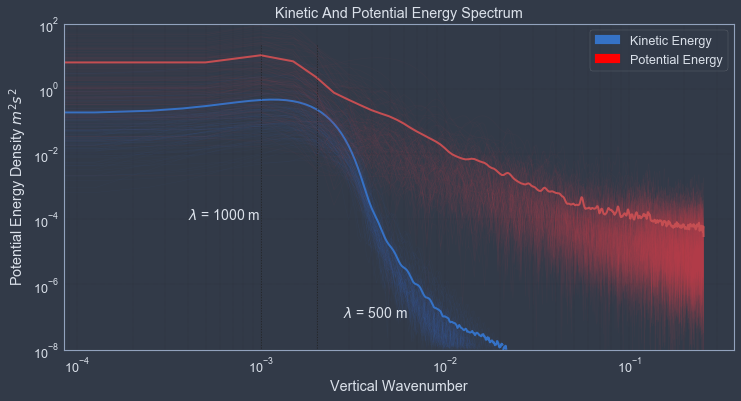

In [6]:
m_plot = np.array([(1)/wl_max,
                       (1)/wl_max, (1)/wl_min,
                       (1)/wl_min])
plt.figure(figsize=[12,6])

plt.loglog(KE_grid, KE_psd.T, linewidth=.6, c='b', marker='x', alpha=.05)
plt.loglog(KE_grid, np.nanmean(KE_psd, axis=0).T, lw=2, c='b')
ylims = plt.gca().get_ylim()
ylim1 = np.array([ylims[0], ylims[1]])
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
plt.ylabel('Kinetic Energy Density')
plt.xlabel('Inverse Vertical Wavelength')
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)

plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T,
           lw=.6, c='r', marker='x', alpha=.05)
plt.loglog(PE_grid, .5*np.nanmean(N2)*np.nanmean(eta_psd, axis=0).T,
           lw=2, c='r')
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim((1e-8, 1e2))
# plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)
plt.ylabel(r'Potential Energy Density $m^2s^2$')
plt.xlabel('Vertical Wavenumber')
plt.title('Kinetic And Potential Energy Spectrum')
# plt.xlim(.0005, .01)
ax = plt.gca()
plt.text(4e-4, 1e-4,r'$\lambda$ = {} m'.format(wl_max))
plt.text(2.8e-3, 1e-7,r'$\lambda$ = {} m'.format(wl_min))
potential = mpatches.Patch(color='red', label='Potential Energy')
kinetic = mpatches.Patch(color='b', label='Kinetic Energy')
plt.legend(handles=[kinetic, potential])
jtplot.style(theme='chesterish')


### Observations from spectra
- On average potential energy is higher than kinetic for this region (is this important for the overall discussion)
- there is a kinetic energy peak (on average) between the target wavelengths (there wouldnt be any peaks at larger wavenumbers because it was filtered using a bandpass filter).
- 

### Notes:
1. Playing around with the integration limits seems to not change the energy or frequency too much but the horizontal wavelengths do seem sensitive to it.  
2. If I want to do the energy flux and ray tracing, I think I will pick a couple select packets and isolate them to get more concrete wavenumbers to use in ray tracing. 
3. Can I use ray tracing to show how energy is trnasported vs dissipated as the wave travels? 
4. There is realy strong surface sher in half the profile (1st half) and it seems like that is stopping waves (or causing them to break not really sure. Also , if vertical wavenumber increases with flow and horizontal wavenumber decreases, what effect does that have on the wave as a whole?



## Decompose Horizontal Wave Vector
In order to properly run a ray tracing model, the horizontal wavenumber $k_h$ must be decomposed into its two components, $k$ and $l$. The horizontal azimuth, $\theta$, is the angle between the $k_h$ vector and the x-axis. using the relationships:

$$ tan(2\theta) = 2\mathbb{R} \bigg [\frac{u'^{*}v'}{u'u^{*} - v'v^{*}} \bigg ]$$

$$ k = (kh)cos(\theta) $$
$$ l = (kh)sin(\theta) $$

where $*$ represents the complex conjugate and $u'$ and $v'$ represent the Fourier transform of velocity anomalies. 
Fourier transforms are done along the same bins used in the energy calculations. (Polzin 2007)

**NOT SO SURE ABOUT HOW RIGHT THIS IS **



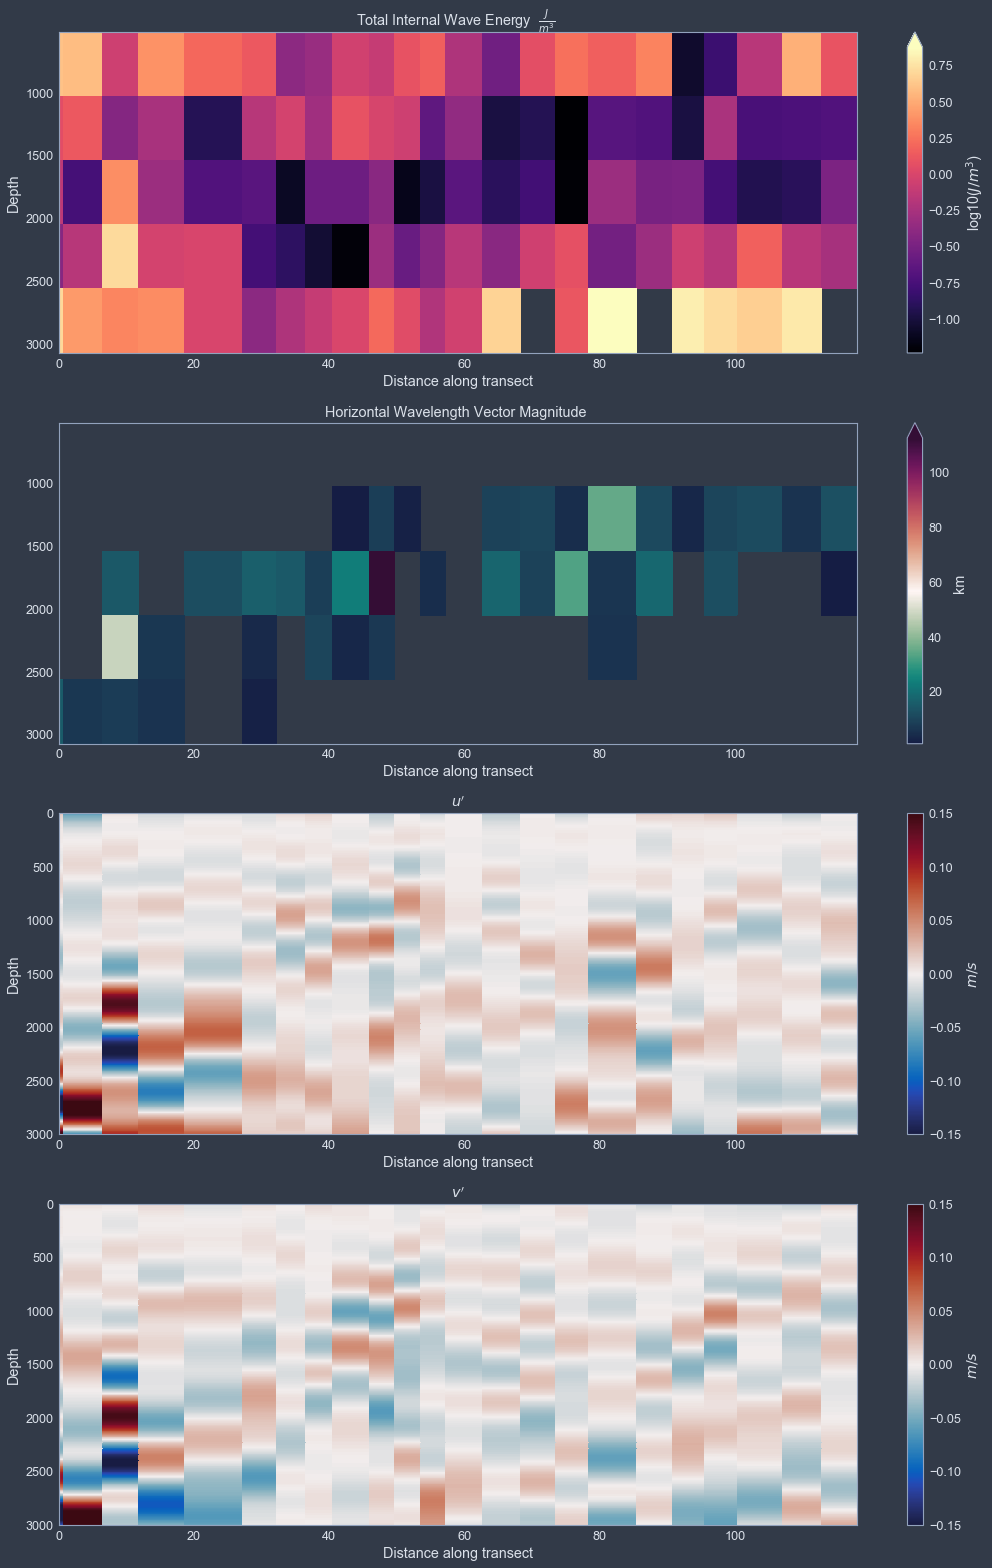

In [14]:
jtplot.reset()
# ENERGY AND WAVE COMPONENT PLOTS
Etotal = 1027*(KE + PE) # Multiply by density to get Joules
# wave components
f = np.nanmean(gsw.f(lat))

# version 2 omega calculation - where did this come from?
omega = f*np.sqrt(((KE+PE)/(KE-PE))) # Waterman et al. 2012 (Ithink)

# m = (2*np.pi)/800

m = (2*np.pi)*np.nanmean(ke_peaks, axis=1)
m = np.reshape(m, KE.shape, order='F') 


kh = m*np.sqrt(((f**2 - omega**2)/(omega**2 - N2mean))) # Waterman et al. 2012
kh2 = (m/np.sqrt(N2mean))*(np.sqrt(omega**2 - f**2)) # Where (meyer i think?)

lambdaH = 1e-3*(2*np.pi)/kh
lambdaH2 = 1e-3*(2*np.pi)/kh2

# version 2 omega calculation
Rw = KE/PE # Unsure what to do with this just yet. 

# Wave vector decomposition
k = []
l = []

theta = []
dz = 8

for i in ladcp_bins:
    theta.append(iwc.horizontal_azimuth(Uprime[i,:], Vprime[i,:], dz,\
                                        wl_min=wl_min,
                                        wl_max=wl_max,
                                        nfft=1024))
theta = np.vstack(theta)

k = kh*np.cos(theta)
l = kh*np.sin(theta)

Elevels = np.linspace(np.nanmin(Etotal), np.nanmax(Etotal), 10)
mask = Etotal > 8
Etotal2 = Etotal
Etotal2[mask] = np.nan
plt.figure(figsize=[15,22])
plt.subplot(411)
plt.pcolormesh(dist.flatten(), depths.flatten(), np.log10(Etotal), cmap='magma')
c1 = plt.colorbar(extend='max')
c1.set_label(r'log10($J/m^3$)')
plt.gca().invert_yaxis()
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r'Total Internal Wave Energy  $\frac{J}{m^{3}}$  ')

mask = lambdaH > 150
norm=colors.LogNorm(vmin=lambdaH.min(), vmax=lambdaH.max())

# lambdaH[mask] = np.nan
plt.subplot(412)
plt.pcolormesh(dist.flatten(), depths.flatten(), (lambdaH), cmap=cmocean.cm.curl, norm=None)
c2 = plt.colorbar(extend='max')
c2.set_label(r'km')
plt.gca().invert_yaxis()
plt.xlabel('Distance along transect')
plt.title('Horizontal Wavelength Vector Magnitude ')


plt.subplot(413)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), (Uprime), 
               cmap=cmocean.cm.balance,
              vmin=-.15, vmax=.15)
c3 = plt.colorbar()
c3.set_label(r'$m/s$')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$u'$")
plt.ylim(0,3000)
plt.gca().invert_yaxis()

plt.subplot(414)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), Vprime, 
               cmap=cmocean.cm.balance,
              vmin=-.15, vmax=.15)
c3 = plt.colorbar()
c3.set_label(r'$m/s$')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$v'$")
plt.ylim(0,3000)
plt.gca().invert_yaxis()

plt.tight_layout()

# plt.subplot(615)
# plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), U,
#                vmin = -.3, vmax= 0.3, cmap=cmocean.cm.delta, shading='flat')
# c3 = plt.colorbar(extend='max')
# c3.set_label(r'$m/s$')
# plt.xlabel('Distance along transect')
# plt.ylabel('Depth')
# plt.title(r"$U $")
# plt.ylim(0,3000)
# plt.gca().invert_yaxis()
# plt.tight_layout()

# plt.subplot(616)
# plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), V,
#                vmin = -.3, vmax= 0.3, cmap=cmocean.cm.delta, shading='flat')
# c3 = plt.colorbar(extend='max')
# c3.set_label(r'$m/s$')
# plt.xlabel('Distance along transect')
# plt.ylabel('Depth')
# plt.title(r"$V $")
# plt.ylim(0,3000)
# plt.gca().invert_yaxis()
# plt.tight_layout()


![title](velocity_anomalies.png)

#### Results Notes:
- Where clear wave features are seen across several consecutive stations, Kinetic energies peak over potential energies, allowing for estimation of wave frequencies. 
- The majority of frequencies are near inertial (~ -.00016 $s^{-1}$ )
- The mean horizontal wavelength (magnitude of kh) is ~15 km

##### Next steps:
- Calculate vertical and horizontal energy and momentum fluxes
- Compare with literature (have to make sure the units are similar)
- Verify the waves are upward propogating (use the rotational component comparison like in Meyer paper)
- Is there a way to see how much energy is dissipating vs how much is being propogated away. 
- __*Maybe rerun calculations specifically targeting the sections the show repeated wave features.*__
- compare energies and fluxes with other papers





# Momentum and energy fluxes
- rainville and pinkel 
- Calculate vertical and horizontal components of momentum and energy fluxes

In [8]:
# calculating momentum fluxes in horizontal and vertical components

## Vertical group speed (assume no mean vertical flow)
cgz = rt.CGz(omega, k , l, m, f, N2mean)
Mz = cgz*Etotal
table = oc.display(Mz, index=depths.flatten())
table.style.set_caption('Horizontal Wavelength V1')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,nan,nan,nan,0.100123,0.0112875,0.0488664,nan,nan,0.000743972,0.00133969,0.00222115,0.000234948,0.00431941,0.00552084,0.00564176,0.00149092,0.00577364,0.00343195,nan
1536.0,nan,nan,0.0138644,nan,0.00538848,0.0018843,0.000241914,0.00228988,0.000818829,0.000139462,nan,0.00314626,nan,0.000841712,0.000979859,0.000156895,0.00725604,0.00101263,nan,0.00221399,nan,nan,0.0245626,nan
2048.0,nan,nan,0.00308134,0.0140381,nan,0.0100128,nan,0.00229672,0.00287792,0.00970529,nan,nan,nan,nan,nan,nan,0.0117725,nan,nan,nan,nan,nan,nan,nan
2560.0,0.00994214,0.037526,0.0227905,0.0388657,nan,0.0196599,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,0.051585,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000790788,2.65103e-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Notes:
The peaks in internal energy visually correlate well with the velocity anamoly graphs where theres packets of similar anomalies. However, I am not sure why the wave numbers are so big (>100km).
* Check whether lee waves can actually form over such big sizes
* All the frequencies are near f. (should be vertically propogating energy (but much slower in the vertical compared to the horizontal because low vertical group speed. 
* Doppler shift the frequencies to see what happens. 



In [9]:
table = oc.display(omega, index=depths.flatten())
table.style.set_caption('Horizontal Wavelength V1')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,nan,nan,nan,-0.00101389,-0.000183325,-0.000553696,nan,nan,-0.000162576,-0.000175417,-0.000331241,-0.000122192,-0.000203347,-0.00044433,-0.000169357,-0.000159512,-0.000280112,-0.000182567,nan
1536.0,nan,nan,-0.000141681,nan,-0.000197367,-0.000147305,-0.000132239,-0.000162037,-0.000128274,-0.000117929,nan,-0.000278083,nan,-0.000140983,-0.000150593,-0.00012525,-0.000198691,-0.000131266,nan,-0.000164761,nan,nan,-0.000870995,nan
2048.0,nan,nan,-0.00011904,-0.000185867,nan,-0.000363653,nan,-0.000190207,-0.000343746,-0.00019704,nan,nan,nan,nan,nan,nan,-0.000259736,nan,nan,nan,nan,nan,nan,nan
2560.0,-0.00012597,-0.000177007,-0.000160165,-0.000190318,nan,-0.000415848,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,-0.000147001,-0.000167873,nan,nan,nan,nan,nan,nan,nan,nan,-0.00013602,-0.000118522,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


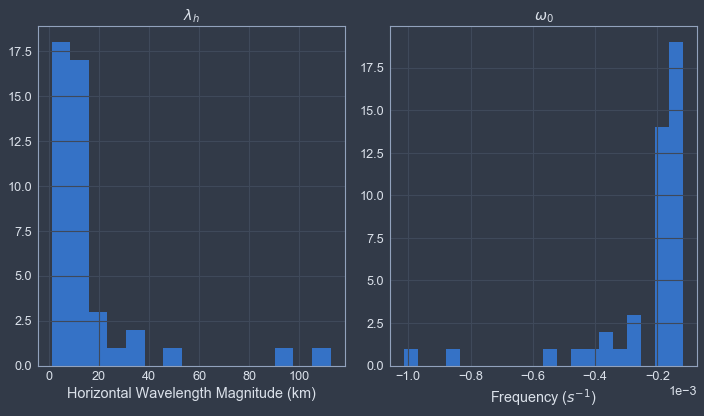

In [10]:
fig = plt.figure(figsize=[10,6])
plt.subplot(121)
plt.hist(lambdaH.flatten(), bins=15, range=(np.nanmin(lambdaH), np.nanmax(lambdaH)))
plt.title(r'$\lambda_h$')
plt.xlabel(r'Horizontal Wavelength Magnitude (km)')
plt.tight_layout()

plt.subplot(122)
plt.hist(omega.flatten(), bins=20, range=(np.nanmin(omega), np.nanmax(omega)))
plt.title(r'$\omega_0$')
plt.xlabel(r'Frequency ($s^{-1}$)')
plt.tight_layout()
ax = plt.gca()
ax.ticklabel_format(style='sci', scilimits=(1,1), axis='x')



In [11]:
table = oc.display(k, index=depths.flatten())
table.style.set_caption(r'Horizontal Wavenumber $k$')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,nan,nan,nan,0.00537686,0.000658301,0.00195436,nan,nan,0.000633847,0.000545075,0.00112842,0.000160676,0.00051196,0.00176378,0.000591619,0.000499874,0.000913904,0.000380271,nan
1536.0,nan,nan,0.0004236,nan,0.00050627,0.000379449,0.000375592,0.000595165,0.000263611,4.94123e-05,nan,0.00100579,nan,0.000262594,0.00052099,0.000186844,0.000941,0.000267894,nan,0.000492588,nan,nan,0.00518134,nan
2048.0,nan,nan,0.000126947,0.000884925,nan,0.00147292,nan,0.000464636,0.00175109,0.000783121,nan,nan,nan,nan,nan,nan,0.000991809,nan,nan,nan,nan,nan,nan,nan
2560.0,0.000396217,0.000699744,0.000666636,0.000882594,nan,0.00197792,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,0.000629923,0.000967829,nan,nan,nan,nan,nan,nan,nan,nan,0.000406746,6.44872e-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [12]:
table = oc.display(l, index=depths.flatten())
table.style.set_caption(r'Horizontal Wavenumber $l$')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,nan,nan,nan,nan,nan,nan,nan,nan,-0.00142047,0.000281561,-0.00174976,nan,nan,0.000209196,0.000268368,0.000557111,7.86445e-05,-0.000234462,-2.91036e-05,6.24332e-05,0.000165506,-0.000472375,-0.000282919,nan
1536.0,nan,nan,-2.08852e-05,nan,4.38495e-05,-2.26563e-05,-0.00016154,0.000395896,-2.88742e-05,2.60992e-05,nan,-0.000805218,nan,-0.000238709,0.000396137,-3.41388e-05,-2.61587e-05,0.000221246,nan,-2.50215e-05,nan,nan,0.00222155,nan
2048.0,nan,nan,-2.80197e-05,-0.000171863,nan,0.000390515,nan,-0.000366092,2.1106e-05,0.000288524,nan,nan,nan,nan,nan,nan,0.000142173,nan,nan,nan,nan,nan,nan,nan
2560.0,-6.6464e-05,0.000564963,0.000318333,0.000508537,nan,-0.00189217,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3072.0,0.000372308,0.000224593,nan,nan,nan,nan,nan,nan,nan,nan,0.000103159,-1.41409e-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
table = oc.display(m, index=depths.flatten())
table.style.set_caption(r'vertical Wavenumber $m$')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
512.0,0.010155,0.0078115,0.0136701,0.00976438,0.00937381,0.0117173,0.00898323,0.00507748,0.00820208,0.0124984,0.00976438,0.0078115,0.00820208,0.00937381,0.00898323,0.0105455,0.00976438,0.00898323,0.00976438,0.00703035,0.00898323,0.0078115,0.00898323,0.0113267
1024.0,0.0062492,0.00703035,0.00898323,0.00859265,0.0113267,0.00898323,0.0078115,0.0105455,0.00859265,0.00937381,0.00859265,0.00663978,0.010155,0.0109361,0.00859265,0.00742093,0.00937381,0.0062492,0.00742093,0.00898323,0.00898323,0.00742093,0.0062492,0.00663978
1536.0,0.00663978,0.0031246,0.0078115,0.00663978,0.0046869,0.0062492,0.00976438,0.00937381,0.00742093,0.00546805,0.0031246,0.00742093,0.00742093,0.00663978,0.010155,0.0062492,0.00859265,0.00859265,0.00663978,0.0062492,0.00195288,0.00820208,0.0078115,0.00742093
2048.0,0.012889,0.00937381,0.00703035,0.00742093,0.00703035,0.00507748,0.00663978,0.0046869,0.0062492,0.0062492,0.00663978,0.00820208,0.00898323,0.0078115,0.00663978,0.00390575,0.00507748,0.00820208,0.00703035,0.00390575,0.00546805,0.00742093,0.00937381,0.00859265
2560.0,0.00898323,0.00703035,0.00703035,0.00703035,0.00507748,0.00663978,0.00859265,0.00820208,0.00546805,0.00546805,0.00859265,0.00703035,0.00585863,0.00390575,0.00663978,0.0078115,0.00820208,0.00937381,0.00546805,0.00585863,0.00585863,0.00663978,0.0078115,0.00663978
3072.0,0.00742093,0.00742093,0.00663978,0.00859265,0.00663978,0.00585863,0.00820208,0.010155,0.00546805,0.00742093,0.00546805,0.0031246,0.00351518,0.00390575,0.00390575,0.0078115,0.0046869,0.0078115,0.0046869,0.0062492,0.0062492,0.0136701,0.00663978,0.00390575


### Ray Tracing
**THESE EQUATIONS HAVE ALL BEEN MODIFIED FOR SATGEM SO THIS STUFF IS NO LONGER BEING USED**
Ray tracing equations are following Olbers 1981 as follows:

Horizontal Group Speeds
$$ C_{gx} = k\frac{N^2 - \omega^2}{\omega(kh^2 + m^2)} $$
$$ C_{gy} = l\frac{N^2 - \omega^2}{\omega(kh^2 + m^2)} $$
Vertical Group Speed:
$$ C_{gz} = m\frac{\omega^2 - f^2}{\omega(kh^2 + m^2)} $$
Change in vertical wavenumber:
$$ \frac{dm}{dt} \approx \frac{dm}{dz} = -\big (k\frac{du}{dz} + l\frac{dv}{dz} \big) $$

Group speeds are multiplied by the specified time step to get x, y, z movements. horizontal wavenumber components are assumed constant (for now). Vertical wavenumber changes with depth (velocity and buoyancy profiles are constant in x,y, and time.

## RAY TRACING WITH OBSERVED WAVES (time reverse)

This section uses the ray tracing module to trace observed waves 

In [31]:
# This is a first attempt at running ray tracing with all the observed wave features.
from datetime import datetime, timedelta
# just use the one date for now (LOAD IN REAL DATETIMES)
towyo_date =  datetime(2012, 2, 28, 21, 33, 44)
plt.figure(figsize=(8,8))
# plt.pcolormesh(lon_b, lat_b, bathy_rev, shading='gouraud')
# plt.contour(lon_b, lat_b, bathy_rev, colors='k')
gem = rt.satGEM_field()
k0 = 0.000379449
l0 = -0.000395896
m0 = -0.0062492
w0 = -0.00014730
wave = rt.Wave(k=k0, l=l0, m=m0, w0=w0, z0=1500,t0=towyo_date,
               lat=lat[:,5], lon=lon[:,5]
              )


rt.run_tracing(wave, gem, duration=24, tstep=25, time_direction='reverse', status=False)



Wave Frequency below inertial Frequency


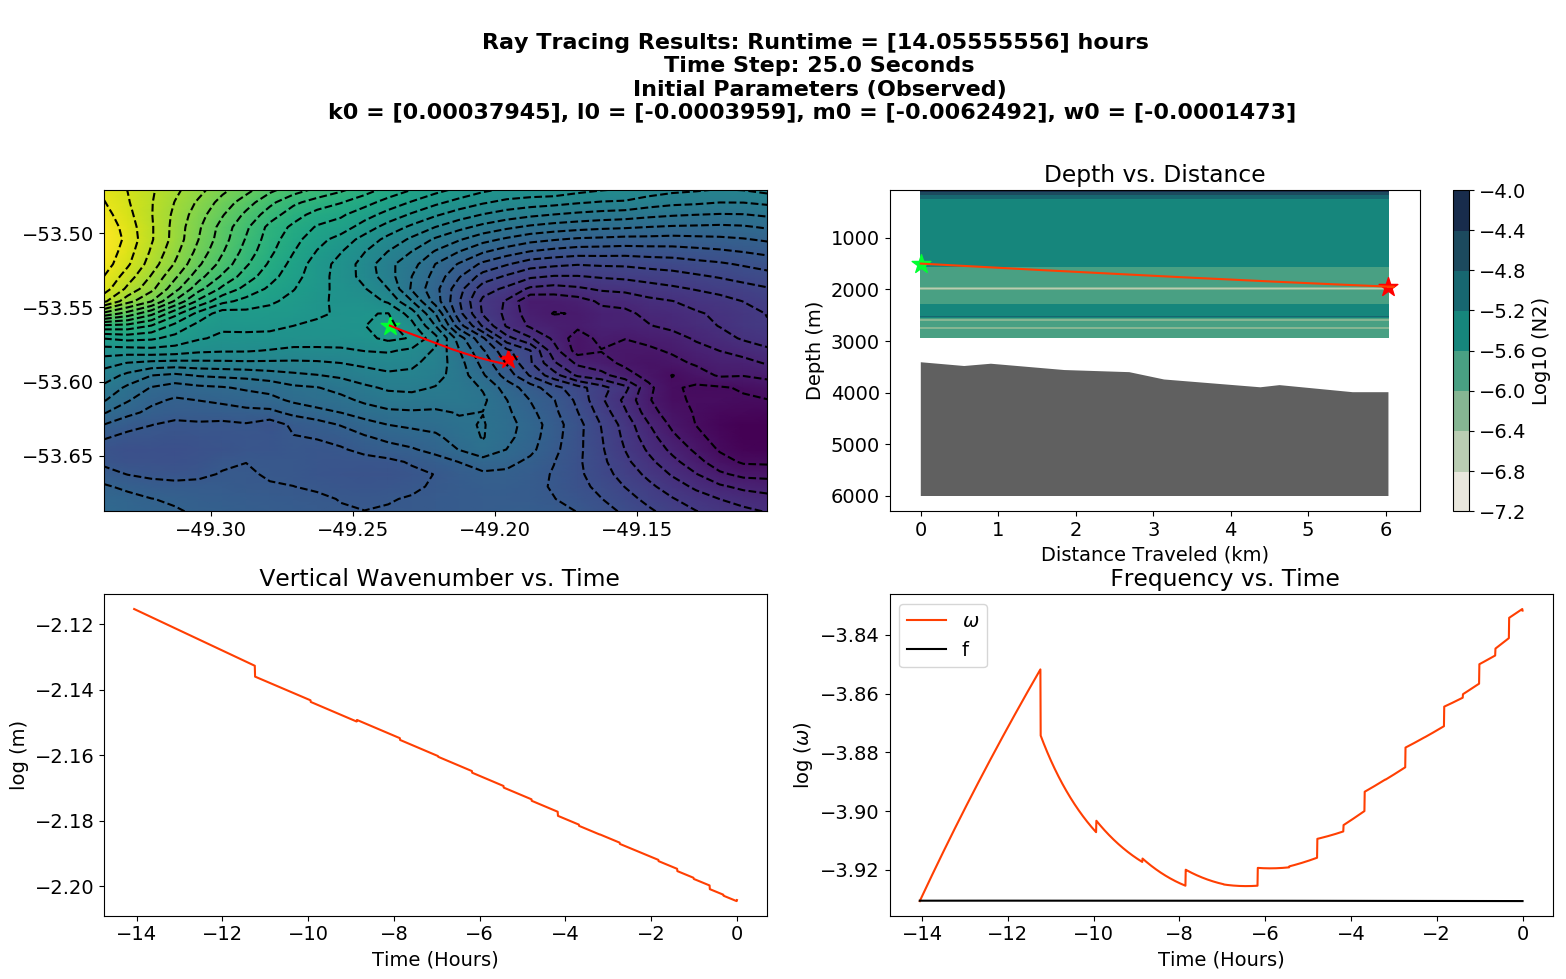

In [32]:
fig1 = rt.dashboard(wave.results, gem, ms=200, buffer=.1, cls=30)


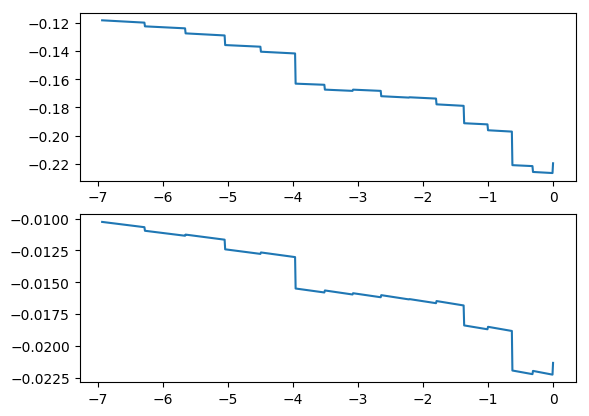

In [439]:
distance = 1e-3 * np.sqrt(results['x']**2 + results['y']**2)
plt.figure()
plt.subplot(211)
plt.plot(results['elapsed_time'][:-1]/3600, results['cgx'])

plt.subplot(212)
plt.plot(results['elapsed_time'][:-1]/3600, results['cgz'])

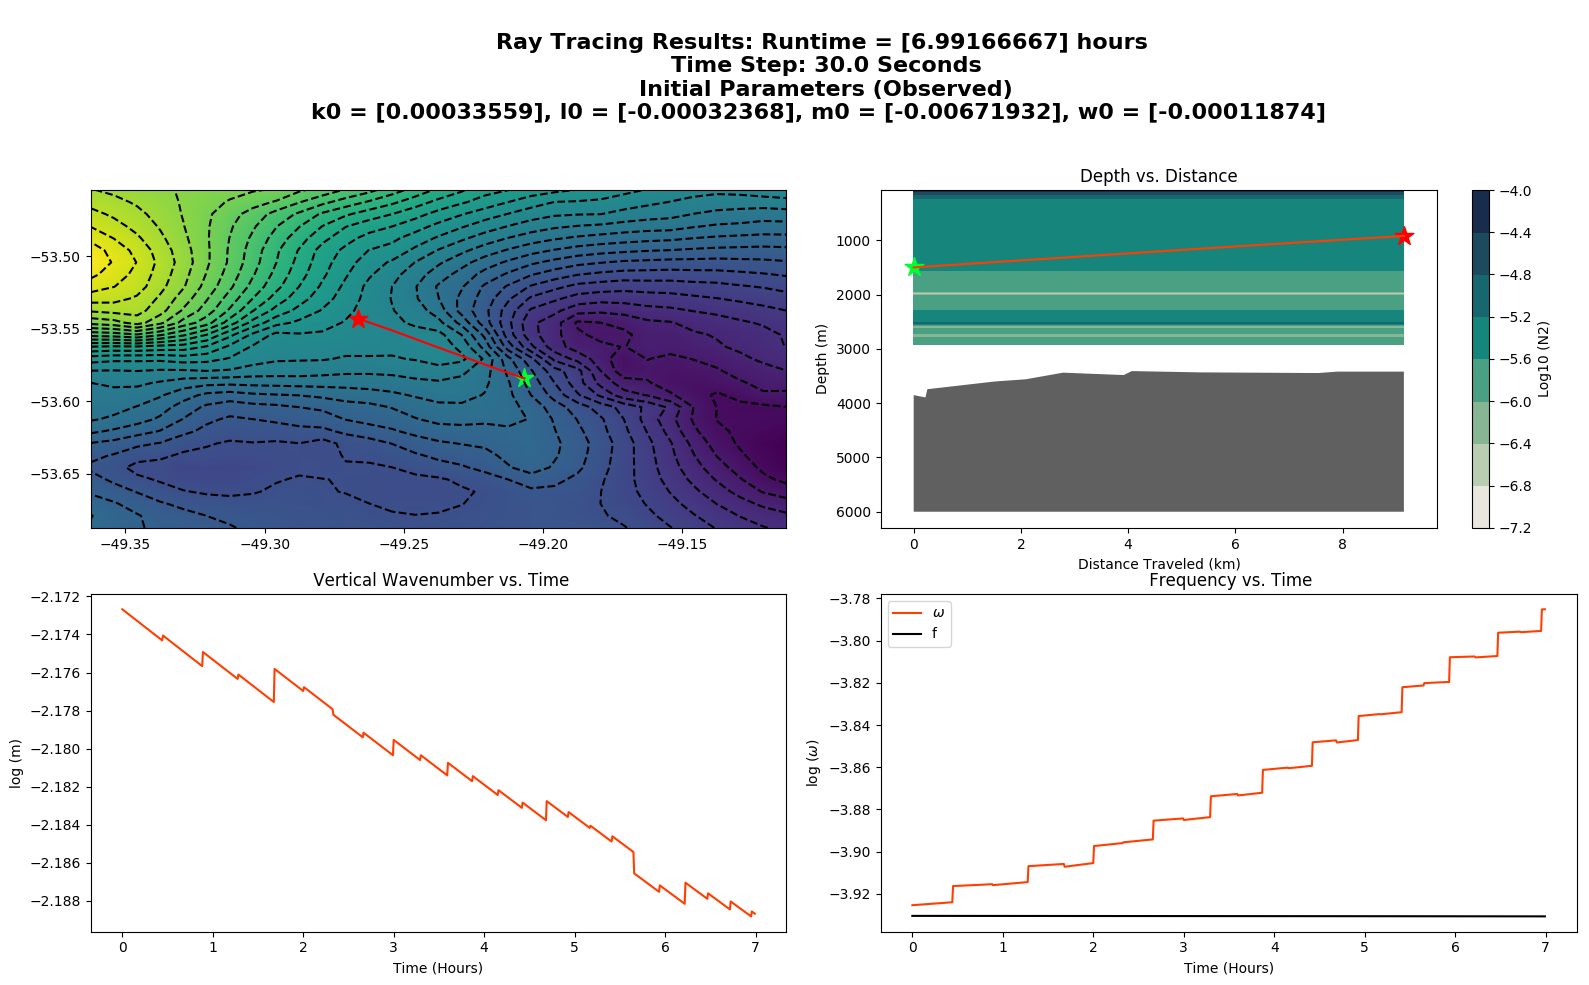

In [469]:
# forward testing
k0 = results['k'][-1]
l0 = results['l'][-1]
m0 = results['m'][-1]
w0 = results['omega'][-3]
wave2 = rt.Wave(k=k0, l=l0, m=m0, w0=w0, z0=1500,
               lat=results['lat'][-1],
               lon=results['lon'][-1],
               t0=results['time'][-1])
gem = rt.satGEM_field()
rt.run_tracing(wave2, gem, duration=7, tstep=30, time_direction='forward', status=False)
fig2 = rt.dashboard(wave2.results, gem, ms=200, buffer=.1, cls=30)

In [30]:
import importlib as imp
imp.reload(rt)


<module 'ray_tracing_satGEM' from '/Users/mdevana/Dropbox/Lee_waves_dissertation/ray_tracing_satGEM.py'>